<img src="./img/HWNI_logo.svg"/>

# Lab 07a - Bootstrapping

In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab07utils as utils 

# Introduction

Below, we'll first work through some of the fundamental operations behind bootstrapping: working with random numbers on computers, generating random numbers with specific distributions, and resampling.

Then, we'll visualize the key components of bootstrapping: the cumulative distribution functions of the population, the sample, and the bootstrap samples.

In the second half of the lab, 07b, we'll use bootstrapping to compute confidence intervals and p-values for the correlation.

A technical note: like Lab 06, this notebook uses the interactive features of JuPyter notebooks. This means that when you generate a plot, you can keep adding things to that plot, so long as you don't either 1) make a new figure or 2) click the blue "power button" in the top-right corner of the figure.

To prevent yourself from accidentally plotting into a figure you didn't mean to plot into, make sure to include a `plt.figure` in each cell where you're making a plot. You'll want to do this before you do the plotting commands (`sns.distplot`,`plt.plot`,etc.).

# Generating Random Numbers

## Computers and Randomness

In [2]:
np.random.standard_normal() #magic?

2.1788194138011856

With a single command above, we are able to ask Python for a number whose exact value we are unable to predict, but whose probability distribution we can describe. Such a number is *random*. You can see this for yourself by running the cell above repeatedly. Different numbers come out each time!

But computers do not behave randomly -- randomness comes from factors that we do not control, and we have very intentionally designed computers in such a way that their macroscopic behavior is essentially unaffected by the factors that we do not control.

Instead, computers behave like functions: if you know their inputs, then you can figure out their outputs. 

When we perform bootstrapping or sampling, we need to generate "random" outputs -- a random shuffling of the labels of our data, for instance. Trouble is, if someone knows everything about the state of our computer, then they can perfectly reproduce the so-called "random" outputs. For statisticians, this turns out to be a problem that's more philosophical than practical -- if we don't know the exact state of our computer, then it *might as well be random* from our perspective. For cryptography, which relies on randomness, this distinction is critical.

This problem is usually solved by measuring something outside the memory of the computer -- the ones digit of the current time in milliseconds or the fifth decimal point of the temperature of the CPU. This number is then used to generate a very long sequence of numbers that have no obvious relationship between them. So long as we don't specifically control the measurement, the resulting output will appear random to us, and all of your statistical operations that rely on randomness will work.

The operation described above is called "seeding" the random number generator. It normally happens when we start using the random parts of numpy or Python, but we can ask for it to happen at any time by using the function `np.random.seed()` (with no arguments).

Run the cell below. Notice that the output is the same each time!

In [3]:
np.random.seed()
np.random.standard_normal()

0.25333589992398975

Now, let's ask Python for another random value using the same function.

In [4]:
np.random.standard_normal()

0.09119231008807878

This number is different from the one generated by the cell with the seed in it, but it's the same if you run the cells one after the other (try it!).

We don't have to use a measurement as our seed. If we provide a (positive) number, Python will happily use that to seed the random number generator.

In [5]:
np.random.seed(5091991)

np.random.standard_normal()

1.9649959891356643

The practical upshot of this is that, if you want, you can make all the code you run *reproducible*, so that someone running your code will get the same thing on their computer, even if it includes a "random" component. In this class, it will allow us to all get the exact same answers, provided we run the same pieces of code in the same order. If you make your results publicly available, this will allow others to directly replicate your results.

## Random Numbers in Python

The numpy library offers just about all of the random number functionality we need for this course. So we proceed after a quick **WARNING**: numpy is not "random enough" to be used in cryptography. If you make a billion-dollar website, don't use numpy for security-critical components of the website.

Numpy's random functions are nice because they are designed to produce lots of random numbers at once. We simply tell numpy the dimensions of the array of random numbers that we want, and it returns it to us.

In [6]:
randomVector = np.random.standard_normal((10,1)) # 10 by 1 random vector
print(randomVector)
print('')

randomMatrix = np.random.standard_normal((3,3)) # 3 by 3 random matrix
print(randomMatrix)
print('')

randomBlock = np.random.standard_normal((2,2,2)) # 2 by 2 by 2 random block
print(randomBlock)
print('')

[[ 1.17936381]
 [ 0.0053099 ]
 [ 0.2859743 ]
 [-0.4813776 ]
 [-2.59799308]
 [-0.1747445 ]
 [-1.14679415]
 [ 1.31048956]
 [-3.27292125]
 [-0.96528963]]

[[-0.26869865  0.117913    0.10455175]
 [ 0.39234959  2.88744766  0.44964858]
 [-0.59689339 -0.96484926  1.18136532]]

[[[ 1.09414916  0.83665013]
  [-1.43010054  1.03967813]]

 [[-0.29965665  1.02348257]
  [-0.59982409  0.49957053]]]



We can confirm that the distribution of these numbers is, in fact, approximately normal by plotting it.

Below, generate at least 1000 samples from a random normal distribution and use seaborn's `distplot` to visualize it however you'd like. Hint: you'll be doing this quite a bit, so if you have a style that you like (I'm partial to `step`-styled histograms) you'll want to write a function that takes in some samples and produces a plot with that style, so you don't have to repeat yourself below.

<IPython.core.display.Javascript object>


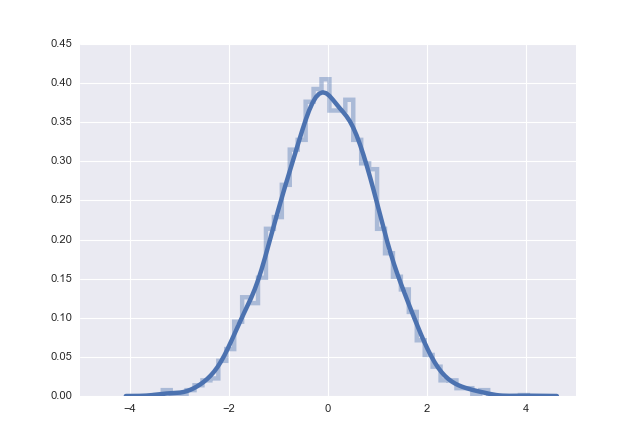

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [7]:
normalSample = np.random.standard_normal(5000)

def plotDistribution(samples,discrete=False):
    
    hist_kws = {'histtype':'step',
            'linewidth':4,}
    
    kde_kws = {'linewidth':4,}
    
    if discrete:
        mini = min(samples)
        maxi = max(samples)
        bins = range(mini,maxi+1)
        sns.distplot(samples,
             hist_kws=hist_kws,
            kde_kws=kde_kws,
            bins=bins);
    else:
        sns.distplot(samples,
             hist_kws=hist_kws,
            kde_kws=kde_kws);

plt.figure()
plotDistribution(normalSample)

`numpy.random.standard_normal` generates samples from the *standard normal distribution*, the normal (aka Gaussian) distribution with a mean of zero and a standard deviation of 1.

If we want normal random variables with a different mean and standard deviation, we simply add the mean and multiply by the standard deviation.

Below, generate another normally-distributed random vector with a different mean and standard deviation and plot the two on the same plot using `distplot`.

<IPython.core.display.Javascript object>


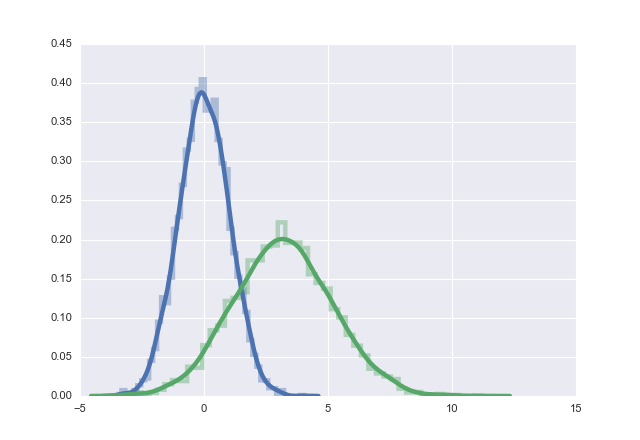

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [8]:
otherNormalVector = 2*np.random.standard_normal(5000)+3.2

plt.figure()
plotDistribution(normalSample)
plotDistribution(otherNormalVector)

Numpy offers many other distributions, some of which we've talked about in class.

Look up (either in numpy's online documentation or using the `function?` method) the random number generating functions below and produce a plot like the one you made above (i.e. comparing at least two large samples generated from distributions with different parameters) for each of them.

- `rand`
- `randint`
- `exponential`

<IPython.core.display.Javascript object>


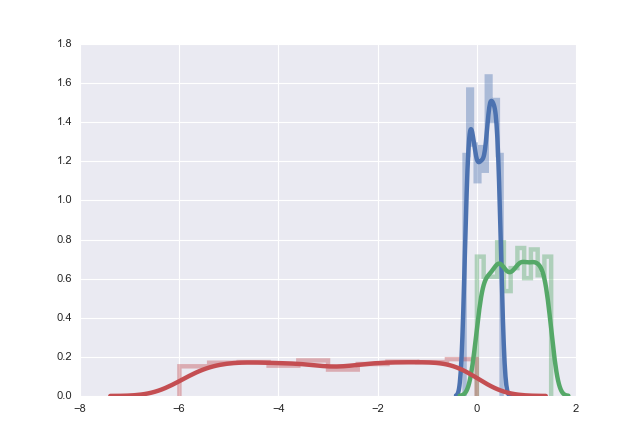

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [9]:
uniform1 = 0.75*np.random.rand(1000)-0.25
uniform2 = 1.5*np.random.rand(1000)
uniform3 = -6*np.random.rand(1000)

plt.figure()
plotDistribution(uniform1)
plotDistribution(uniform2)
plotDistribution(uniform3)

<IPython.core.display.Javascript object>


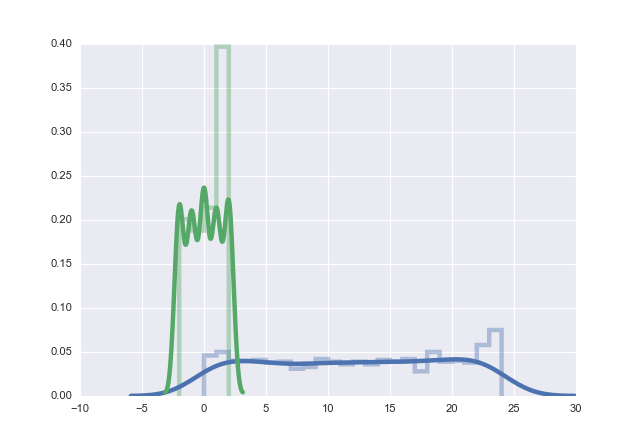

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [10]:
randint1 = np.random.randint(0,25,size=1000)
randint2 = np.random.randint(-2,3,size=1000)

plt.figure()

plotDistribution(randint1,discrete=True)
plotDistribution(randint2,discrete=True)

<IPython.core.display.Javascript object>


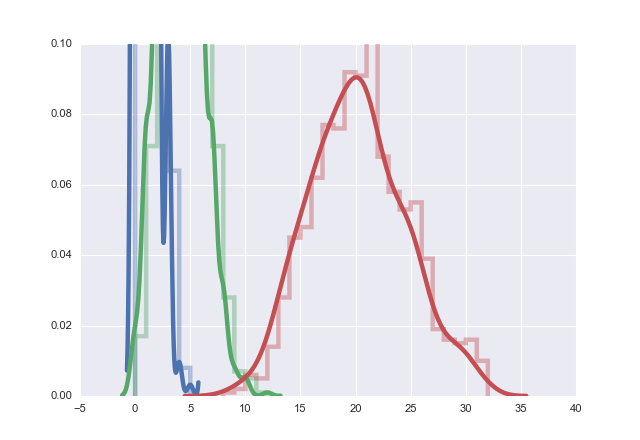

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [11]:
lowPoisson = np.random.poisson(1,size=1000)
middlePoisson = np.random.poisson(4,size=1000)
highPoisson = np.random.poisson(20,size=1000)

plt.figure()
plotDistribution(lowPoisson,discrete=True)
plotDistribution(middlePoisson,discrete=True)
plotDistribution(highPoisson,discrete=True)

## Estimating the Sampling Distribution

One of the key ideas in statistics is the idea of the *sampling distribution of the statistic*.

#### Q What's your definition of the sampling distribution of a statistic?

<font color="1874CD"> ** There are lots of different answers here. I wrote a 
[blog post](http://charlesfrye.github.io/stats/2017/02/24/statistics-as-pushforward.html)
about my (very mathy!) preferred definition. The one we use most in class is "the distribution of your statistic across samples".**

In the cell below, plot the sampling distribution of a statistic of your choice based on a population distribution of your choice.

You'll need to do the following:

- Use numpy's random number generators to repeatedly sample from a distribution.
- Calculate the value of the statistic on each sample.
- Use seaborn's `distplot` to plot these values. This means your statistic has to be a number.

<IPython.core.display.Javascript object>


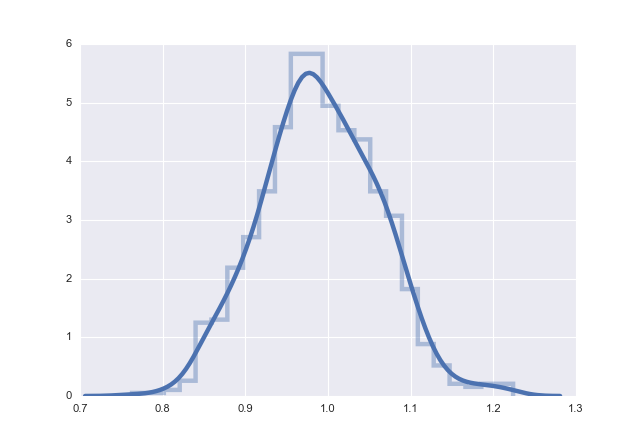

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [12]:
numSamples = 1000
sampleSize = 100

samples = [np.random.standard_normal(size=sampleSize) 
               for _ in range(numSamples)]

statistics = [np.std(sample) for sample in samples]

plt.figure();
plotDistribution(statistics)

#### Q What happens to the sampling distribution as you increase the sample size? Hint: look at the x-axis.

Note: not everyone will get the same answer here.

<font color='1874CD'> **If you picked a reasonable statistic and a distribution with finite spread, the sampling distribution gets thinner as the sample size grows.**

## Sampling from a Set in Python

The random number generating functions above will be useful when we want to simulate a data-generating process. For example, I've used them to make the simulated data for the labs in this course.

In bootstrapping, however, we don't sample from a parametrized distribution, as above. Instead, we sample from our data directly. If you were to implement this by hand, drawing a single sample might look something like this:

1. Write down all of the data values on pieces of paper.
1. Put the pieces of paper in a hat.
1. Shake the hat up and blindly draw a single slip.
1. The value on that slip is the value you sampled.

When bootstrapping, we draw our samples "with replacement", which is to say that, if we wanted to draw more than one sample, we'd add two more steps. In step 5, we'd put the slip we drew back in, and then in step 6, we'd repeat steps 3-5 until we had enough samples.

In numpy, sampling from a 1-D array with or without replacement is implemented with the function `np.random.choice`. In the cell below, generate a dataset using one of the sampling functions above, then print it, and then sample from it, with replacement, using `np.random.choice`.

In [13]:
data = np.random.poisson(size=10)
print(data)

for _ in range(10):
    resample = np.random.choice(data,size=1)
    print(resample)

[0 2 0 1 1 4 0 0 0 1]
[0]
[0]
[2]
[1]
[1]
[2]
[1]
[0]
[0]
[2]


`np.random.choice` is designed for 1-D datasets. For datasets that are 2-D or larger, we instead use `np.random.randint(low,high)`, which generates a random integer at least as big as `low` but less than `high`. When `low` is 0 and `high` is the length of the dataset, we can use the resulting list to index into the data array.

You'll need this for the second half of the lab.

In [14]:
data = np.random.poisson(size=10)
print(data)

for _ in range(10):
    randomIndices = np.random.randint(0,len(data),size=3)
    resample = data[randomIndices]
    print(resample)

[1 2 1 1 1 2 3 0 1 2]
[1 2 1]
[3 1 1]
[1 1 1]
[2 2 2]
[1 1 1]
[0 1 0]
[1 2 2]
[2 1 2]
[1 2 3]
[1 1 2]


# Visualizing Empirical Distributions

## Empirical Distributions Don't Have Probability Density Functions

The idea of an empirical distribution arises naturally -- we're just sampling with replacement from our data, after all. However, they're a very tricky thing to visualize correctly. The below set of exercises will show you why we can't write down a probability density function for the empirical distribution.

First, generate a data sample from the standard `uniform` distribution. In the interest of computation time, pick a small sample size, like 5 or 15.

In [15]:
data = np.random.uniform(size=15)

Now, plot the data using `distplot`. Include both the `kde` and the `hist`ogram but not the `rug`plot. Start with a small bin size, like 0.1.

<IPython.core.display.Javascript object>


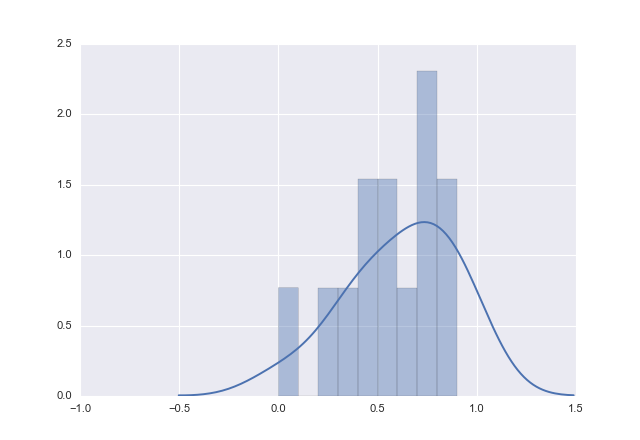

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [16]:
binsize = 1e-1
bins = np.arange(start=0,step=binsize,stop=1)

plt.figure()

sns.distplot(data,bins=bins);

Note that the values on the y-axis are sometimes higher than 1. As we discussed at the beginning of the course, this is somewhat counter-intuitive.

#### Q What does the y-axis represent? Why is it OK that it goes above 1?

<font color="1874CD"> ** It represents the probability *density* at each point. This is not to be confused with the probability, which cannot be greater than 1. **

Now, reduce the binsize above to a smaller number -- divide by five or more -- and plot the data again.

#### Q What happens to the histogram?

<font color="1874CD"> ** The heights of the bars get taller as they get skinnier! **

We can keep making the bin size smaller and smaller -- though it starts taking longer and longer for Python to compute the histogram.

The "empirical distribution" corresponds to a binsize of *exactly* 0.

#### Q Give an intuitive explanation for why this is the case and why this is a problem for viewing the empirical distribution as a density.

<font color="1874CD"> ** The empirical distribution puts a probability of $1/n$ at each data *poin*. That means that there's a finite amount of mass on something with zero volume. When we go to calculate the density, we have a finite number over 0, and we get $\infty$! **

This means that we don't really have a probability density for our empirical distribution, so we can't visualize it the way we do other probability densities.

When we do want to visualize a data distribution directly, we often "cheat" and use something like a rugplot or a scatterplot. 

#### Q Think about the benefits and drawbacks of using the rugplot as a stand-in for the empirical distribution. You might compare it to a kernel density estimate or a stripplot. Write your thoughts down here.

<font color="1874CD"> ** The rugplot "works" in that it lets us know where the datapoints lie, but it runs into issues when there's more than one datapoint in the same spot and it doesn't do a great job showing the density of points -- it's not as easy to read off relative densities from a rugplot as it is from a kernel density estimate. Stripplots with jitter are often better for continuous data and swarmplots can handle discrete or continuous or mixed data fairly well. Kernel densities do OK on data that can take on any value on the number line, but do badly outside of that regime. **

## Empirical Distributions Do Have Cumulative Density Functions

We can still accurately visualize empirical distributions, we just need a different tool - the cumulative density function.

Recall that the cumulative density function ("CDF") of a random variable $X$ tells us, for any value $x$, the chance that the random value $X$ is less than or equal to $x$.

In the cell below, generate a dataset from the probability distribution of your choosing and then plot the cumulative distribution function for the empirical distribution. It should look like a "staircase" that goes up in level by $\frac{1}{N}$ every time it passes a datapoint.

Some things to note:

- You'll want to use the `pyplot` (alias `plt`) function `.plot`. You only need its simplest features: if you put in two arrays, `xs` and `ys`, it will draw a line that connects all the x,y pairs. The function call will look like `plt.plot(xs,ys)`. `xs` and `ys` need to be the same length.

- The CDF is a function that is defined for all inputs, not just for points that happen to be data points. If you want to plot the CDF correctly, it has to give the right answer for things that aren't in the dataset.

- For the more advanced programmers: the cleanest way to do this is to make a function, `makeECDF`, that takes in a dataset and returns a function, `eCDF`, that acts like the empirical CDF. If you feel comfortable with Python, you should try this yourself!

<IPython.core.display.Javascript object>


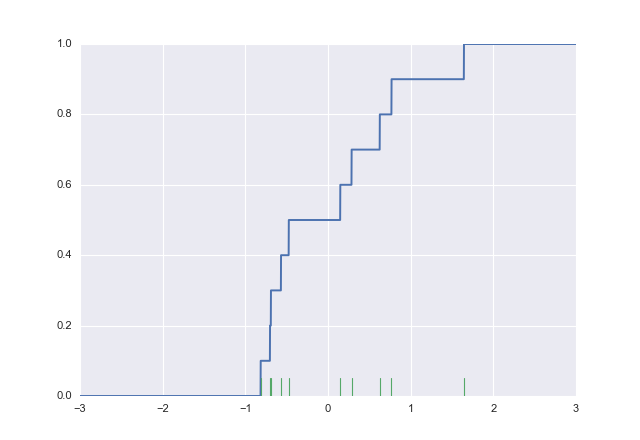

In [17]:
data = np.random.standard_normal(size=10)

eCDF = utils.makeECDF(data)

inputRange = np.arange(-3,3,0.001)

plt.figure()
plt.plot(inputRange,[eCDF(input) for input in inputRange])
sns.distplot(data,kde=False,hist=False,rug=True);

Add a `rugplot` to your visualization of the CDF.

#### Q How are these two plots connected?

<font color="1874CD"> ** Wherever there's a tick mark on the rug plot, there's a step up on the CDF. **

# Visualizing Bootstrapping

## Visualizing Sample eCDFs

The cell below will generate an animation that shows the true cumulative distribution function of a random variable in black along with the empirical cumulative distribution functions (eCDFs, for short) of different samples of the same size. You can control the number of samples with the keyword argument `numSamples` and the sample size with the keyword argument `sampleSize`. It defaults to sampling a standard normal variable -- read the documentation (with `util.plotSamples?`) if you'd like to sample a different variable.

<IPython.core.display.Javascript object>


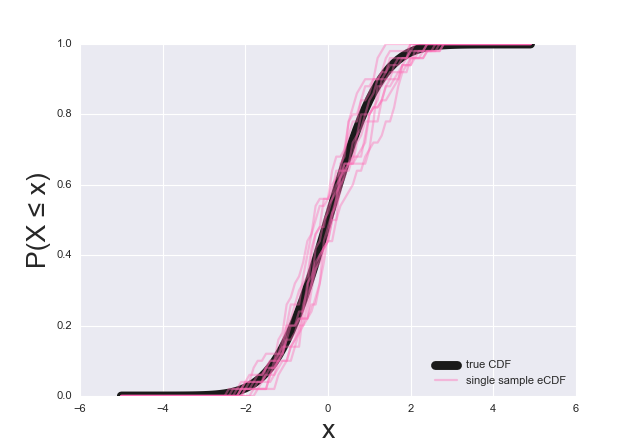

In [18]:
utils.plotSamples(sampleSize=50)

Set the sample size to a small value -- less than 5.

#### Q How close are the individual eCDFs to the true, population CDF?

<font color="1874CD"> ** At a low sample size, the individual CDFs are quite far apart. **

#### Q What would you say the "average" of the eCDFs looks like?

<font color="1874CD"> ** On average, the eCDFs are much closer to the true CDF. **

Increase the sampleSize by a factor of 10 or more.

#### Q What happens to each eCDF individually? What happens to the eCDFs as a group?

<font color="1874CD"> ** The individual eCDFs become closer to the true CDF. The group becomes less spread out. **

The next cell will animate the process of taking successively bigger samples. With each frame of the animation, the eCDF of a sample of increasing size will be plotted over the true, population CDF. In each frame, the sample size appears in the top center of the plot.

<IPython.core.display.Javascript object>


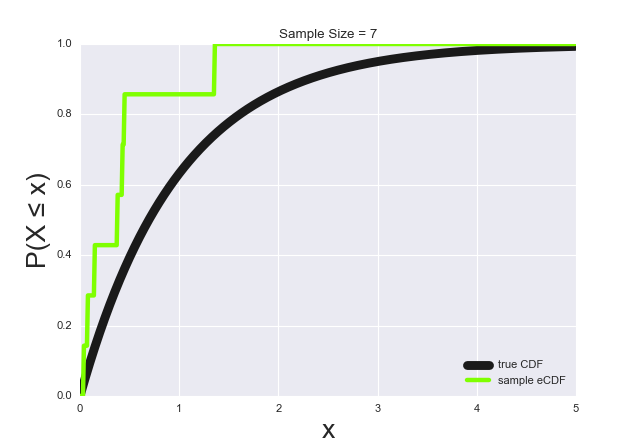

In [19]:
sampler = np.random.standard_exponential
trueCDF = scipy.stats.expon.cdf

inputRange = np.arange(0,5,0.01)

sampleSizes = [1,2,3,4,5,6,7]

utils.plotConvergingCDF(sampler=sampler,
                  trueCDF=trueCDF,
                  inputRange=inputRange,
                 sampleSizes=sampleSizes)

#### Q What happens to the eCDF as the number of samples goes up?

<font color="1874CD"> ** It gets closer to the the true CDF. **

You can change which sample sizes are plotted by providing a list of sample sizes as the keyword argument `sampleSizes`.

Set the sample sizes so that they only change by one with each frame of the animation -- for example, the list `[1,2,3,4,5]` works.

Once you've got the above working, pick a particular value of x. Watch how the eCDF changes at that point as the sample size goes up.

#### Q Frame by frame, does the eCDF always get closer to the true CDF at that point? Is this surprising?

<font color="1874CD"> ** No it does not. Maybe it is. **

#### Challenge Q Taking the last question into account, can you describe the sense in which the eCDF is "getting closer" to the true CDF?

<font color="1874CD"> ** There are (at least) two good answers to this question. For one, we should *expect* a point to get closer to the eCDF, rather than further, even if it doesn't do that every time. For another, the probability that any point on the eCDF is a given distance away from its partner on the CDF is going down over time. We can make this even stronger: the probability that the greatest distance, over all points, between points on the eCDF and the CDF is bigger than any given value is going down over time. **

### Visualizing Bootstrap eCDFs

Finally, let's visualize the bootstrap itself.

The cell below will first plot the true CDF of a population.

Then, it will draw a sample from that distribution and plot the empirical CDF.

Lastly, it will perform a number of bootstrap resamplings from this distribution. As is usual for the bootstrap, we'll draw, with replacement, as many times as there are points in our dataset. The eCDF for each bootstrap sample is then plotted as a thin, transparent line.

<IPython.core.display.Javascript object>


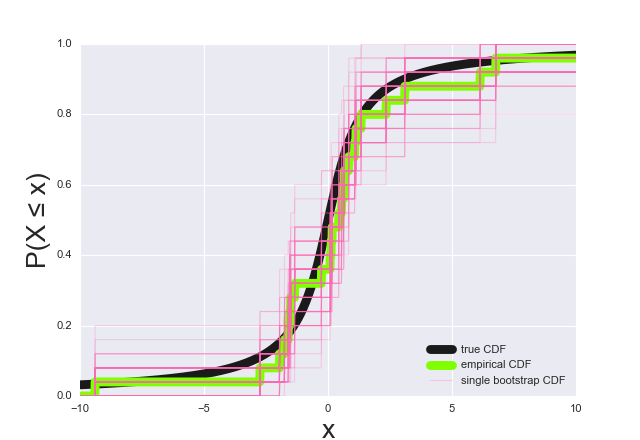

In [20]:
sampler = np.random.standard_cauchy
trueCDF = scipy.stats.cauchy.cdf

inputRange = np.arange(-10,10,0.01)

utils.plotBootstraps(sampler=sampler,
               trueCDF=trueCDF,
               inputRange=inputRange,
               sampleSize=25,
                numBootstraps=100)

#### Q Are the individual bootstrap CDF curves close to the true CDF? What about on average?

<font color="1874CD"> ** Individually, they can be quite far away, but their average is fairly close. **

Decrease the sample size (`sampleSize`) to 5.

#### Q What would you say the average bootstrap CDF is?

<font color="1874CD"> ** The smaller sample size makes it clear that the average is the empirical CDF, rather than the true CDF. **

# More Visualizations

If you'd like, you can view the CDFs, eCDFs, and bootstrapping behavior of more distributions by changing the `sampler` and `trueCDF` keyword arguments to all of the functions above. Note that `sampler`s come from numpy while `trueCDF`s come from `scipy.stats`. Note that you don't want to *call* the functions (that is, follow them with parentheses), you want to pass the functions themselves as arguments.

When you do this, you'll want to change the `inputRange` argument -- it's best if it covers 95-99% of the possible values.

Some example pairs:

1. `np.random.standard_exponential` and `scipy.stats.expon.cdf`
1. `np.random.standard_cauchy` and `scipy.stats.cauchy.cdf`